In [1]:
import pandas as pd
from transformers import MarianMTModel, MarianTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from datasets import load_dataset, Dataset, DatasetDict
from torch.utils.data import DataLoader
# Replace the AdamW import with this:
from torch.optim import AdamW  # Import AdamW from torch.optim instead
from transformers import get_scheduler  # This should still work
import evaluate
import numpy as np
from tqdm.auto import tqdm
import accelerate
import torch
import time
from datetime import datetime
import os

/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "Helsinki-NLP/opus-mt-es-ar"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

In [3]:
train_df = pd.read_csv('/home/maquiroz/mixtec_translation_project/data/processed/train.csv')
val_df = pd.read_csv('/home/maquiroz/mixtec_translation_project/data/processed/val.csv')
test_df = pd.read_csv('/home/maquiroz/mixtec_translation_project/data/processed/test.csv')

# Verify data loaded correctly
print(f"Train set: {len(train_df)} examples")
print(f"Validation set: {len(val_df)} examples")
print(f"Test set: {len(test_df)} examples")

train_df.head()

Train set: 13852 examples
Validation set: 1732 examples
Test set: 1732 examples


,spanish,arabic
0,¿quì vas a hacer esta noche?,ماذا ستفعل الليله بعد مغادرتي؟
1,incluye también el océano artico y todo el con...,وتشمل ايضا المحيط القطبي الشمالي وقاره انتاركت...
2,"hola, ¿quieres un bocadillo?",مرحبا ، ما رايك بوجبه؟
3,"aldeas de gizil oba y yarymdzha, región de tar...",قريتا غيزيل اوبا وياريمدزها، منطقه ترتر، اذربيجان
4,- [gladys] ¿me oíste?,‫‏ - هل سمعتني؟ ‫‏


In [4]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Convert dataframes to HF Dataset format
def df_to_dataset(df):
    return {
        "translation": [
            {"es": row["spanish"], "ar": row["arabic"]} 
            for _, row in df.iterrows()
        ]
    }

In [6]:
train_dataset = Dataset.from_dict(df_to_dataset(train_df))
val_dataset = Dataset.from_dict(df_to_dataset(val_df))
test_dataset = Dataset.from_dict(df_to_dataset(test_df))

In [7]:
# Combine into a DatasetDict
datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

In [8]:
print(f"Train set: {len(train_dataset)} examples")
print(f"Validation set: {len(val_dataset)} examples")
print(f"Test set: {len(test_dataset)} examples")

Train set: 13852 examples
Validation set: 1732 examples
Test set: 1732 examples


In [9]:
print("Dataset structure:")
print(train_dataset[0])  # Print the first example to see its structure

Dataset structure:
{'translation': {'ar': 'ماذا ستفعل الليله بعد مغادرتي؟', 'es': '¿quì vas a hacer esta noche?'}}


In [10]:
train_examples = []
for example in train_dataset:
    train_examples.append({
        "spanish": example["translation"]["es"],
        "arabic": example["translation"]["ar"]
    })

val_examples = []
for example in val_dataset:
    val_examples.append({
        "spanish": example["translation"]["es"],
        "arabic": example["translation"]["ar"]
    })

test_examples = []
for example in test_dataset:
    test_examples.append({
        "spanish": example["translation"]["es"],
        "arabic": example["translation"]["ar"]
    })

# Create new datasets with the flat structure
new_train_dataset = Dataset.from_list(train_examples)
new_val_dataset = Dataset.from_list(val_examples)
new_test_dataset = Dataset.from_list(test_examples)

# Combine into a DatasetDict
new_datasets = DatasetDict({
    "train": new_train_dataset,
    "validation": new_val_dataset,
    "test": new_test_dataset
})

# Check the new structure
print("New dataset structure:")
print(new_train_dataset[0])

New dataset structure:
{'spanish': '¿quì vas a hacer esta noche?', 'arabic': 'ماذا ستفعل الليله بعد مغادرتي؟'}


In [11]:
def preprocess_function(examples):
    # Tokenize Spanish inputs
    model_inputs = tokenizer(
        examples["spanish"], 
        max_length=128,
        padding="max_length", 
        truncation=True
    )
    
    # Tokenize Arabic targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["arabic"],
            max_length=128,
            padding="max_length",
            truncation=True
        )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [12]:
# Apply preprocessing to all datasets
tokenized_datasets = new_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=["spanish", "arabic"]
)

# Check if tokenization worked
print("Tokenized dataset structure:")
print(tokenized_datasets["train"][0])

Map:   0%|                                                                          | 0/13852 [00:00<?, ? examples/s]/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████████████████████████████████████████████████████████| 1732/1732 [00:00<00:00, 1794.82 examples/s]

Tokenized dataset structure:
{'input_ids': [37, 18746, 61548, 2535, 13, 270, 204, 1688, 35, 0, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517, 62517], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
# Create a data collator that will take care of padding and creating tensors
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding=True,
    return_tensors="pt"
)

In [14]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results/marian_es_ar",
    eval_strategy="epoch",
    learning_rate=2e-5,  # Lower learning rate for fine-tuning
    per_device_train_batch_size=16,  # Adjust if you get OOM errors
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,  # Mixed precision
    report_to=None,  # Disable TensorBoard
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
)

In [15]:
# Define metrics for evaluation
metric = evaluate.load("sacrebleu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # Replace -100 with pad token id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    
    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Compute BLEU score
    result = metric.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])
    return {"bleu": result["score"]}

In [16]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_342921/1485828738.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [17]:
# Print dataset sizes to verify
print(f"Training on {len(tokenized_datasets['train'])} examples")
print(f"Validating on {len(tokenized_datasets['validation'])} examples")

Training on 13852 examples
Validating on 1732 examples


In [18]:
# 6. Train the model
print("Starting training...")
trainer.train()

Starting training...


/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu
1,0.809200,0.347065,10.633932
2,0.361500,0.326969,14.761230
3,0.342300,0.322452,14.965246


/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62517]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=372, training_loss=0.4722303831449119, metrics={'train_runtime': 1502.2438, 'train_samples_per_second': 27.663, 'train_steps_per_second': 0.248, 'total_flos': 1408680452947968.0, 'train_loss': 0.4722303831449119, 'epoch': 3.0})

In [19]:
# Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.evaluate(tokenized_datasets["test"])
print(f"Test results: {test_results}")

Evaluating on test set...


/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test results: {'eval_loss': 0.331432580947876, 'eval_bleu': 13.692052462316509, 'eval_runtime': 371.6379, 'eval_samples_per_second': 4.66, 'eval_steps_per_second': 0.043, 'epoch': 3.0}


In [20]:
# Save the fine-tuned model
model_save_path = "./models/marian_es_ar_finetuned"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./models/marian_es_ar_finetuned


### Sample Translations and Analysis:

In [21]:
model.to(device)  # Ensure model is on the right device

test_examples = test_df.head(10)
for i, row in test_examples.iterrows():
    spanish_text = row["spanish"]
    gold_arabic = row["arabic"]
    
    # Translate
    inputs = tokenizer(spanish_text, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_length=128)
    pred_arabic = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    print(f"Spanish: {spanish_text}")
    print(f"Predicted Arabic: {pred_arabic}")
    print(f"Reference Arabic: {gold_arabic}")
    print("-" * 50)

Spanish: tal vez debería saludar a los muftic.
Predicted Arabic: ربما يجب ان اسلم علا المءتمرين
Reference Arabic: ربما ينبغي علي ان اسلم علا عاءله موفتكس
--------------------------------------------------
Spanish: informe del secretario general sobre la consolidación de la paz después de los conflictos (s/2012/746)
Predicted Arabic: تقرير الامين العام عن بناء السلام بعد انتهاء النزاع (S/2012/746)
Reference Arabic: تقرير الامين العام عن بناء السلام في اعقاب انتهاء النزاع (S/2012/746)
--------------------------------------------------
Spanish: - ¿te despidieron?
Predicted Arabic: ‫ - هل طردت؟‬ ‫
Reference Arabic: - هل طردت؟
--------------------------------------------------
Spanish: por consiguiente, esperamos que la conferencia de doha aliente el logro de un consenso y conduzca a nuevos progresos a fin de establecer los mecanismos que la comunidad internacional necesita para enfrentar los problemas más apremiantes de la salud y el clima.
Predicted Arabic: ولذلك، يحدونا الأمل في ان يشجع 

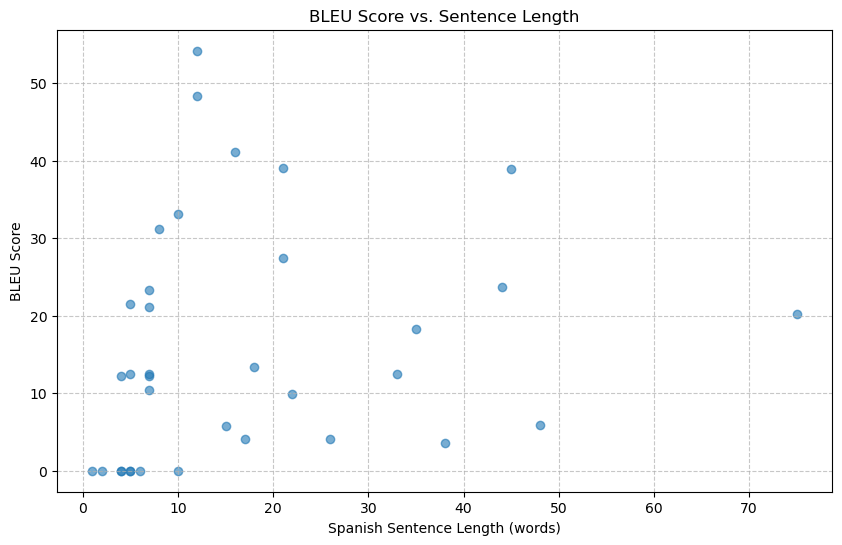

In [22]:
# Analyze performance by sentence length
import matplotlib.pyplot as plt

lengths = []
bleu_scores = []

for i, row in test_df.iterrows():
    if i % 50 == 0:  # Sample to avoid processing the entire test set
        spanish_text = row["spanish"]
        gold_arabic = row["arabic"]
        
        # Translate
        inputs = tokenizer(spanish_text, return_tensors="pt").to(device)
        outputs = model.generate(**inputs, max_length=128)
        pred_arabic = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Calculate BLEU for this sentence
        sentence_bleu = metric.compute(predictions=[pred_arabic], references=[[gold_arabic]])
        
        # Record length and BLEU
        lengths.append(len(spanish_text.split()))
        bleu_scores.append(sentence_bleu['score'])

# Plot relationship between sentence length and BLEU
plt.figure(figsize=(10, 6))
plt.scatter(lengths, bleu_scores, alpha=0.6)
plt.title('BLEU Score vs. Sentence Length')
plt.xlabel('Spanish Sentence Length (words)')
plt.ylabel('BLEU Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('bleu_vs_length.png')
plt.show()

In [23]:
def translate_spanish_to_arabic(spanish_text, model, tokenizer, device="cuda"):
    """Translate Spanish text to Arabic using the fine-tuned model."""
    # Preprocess input
    inputs = tokenizer(spanish_text, return_tensors="pt").to(device)
    
    # Generate translation
    outputs = model.generate(
        **inputs,
        max_length=128,
        num_beams=5,
        early_stopping=True
    )
    
    # Decode output
    arabic_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return arabic_text

In [24]:
test_sentences = [
    "Hola, ¿cómo estás?",
    "El clima está muy agradable hoy.",
    "Me gustaría visitar el museo mañana."
]

for sentence in test_sentences:
    translation = translate_spanish_to_arabic(sentence, model, tokenizer, device)
    print(f"Spanish: {sentence}")
    print(f"Arabic: {translation}")
    print("-" * 50)

Spanish: Hola, ¿cómo estás?
Arabic: مرحبا، كيف حالك؟
--------------------------------------------------
Spanish: El clima está muy agradable hoy.
Arabic: الطقس جميل اليوم.
--------------------------------------------------
Spanish: Me gustaría visitar el museo mañana.
Arabic: اود ان ازور المتحف غدا
--------------------------------------------------


### different beam search settings for generation

In [25]:
# Exploring different decoding strategies
print("Testing different decoding strategies...")

test_sentences = test_df.head(5)["spanish"].tolist()

# Define different generation parameters to try
generation_params = [
    {"num_beams": 1, "max_length": 128, "name": "Greedy search"},
    {"num_beams": 5, "max_length": 128, "name": "Beam search (5)"},
    {"num_beams": 5, "max_length": 128, "early_stopping": True, "name": "Beam search with early stopping"},
    {"num_beams": 5, "max_length": 128, "length_penalty": 1.5, "name": "Beam search with length penalty"},
    {"do_sample": True, "top_k": 50, "top_p": 0.9, "max_length": 128, "name": "Sampling (top-k + top-p)"}
]

results = []

for sentence in test_sentences:
    print(f"\nTranslating: {sentence}")
    
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    reference = test_df[test_df["spanish"] == sentence]["arabic"].iloc[0]
    
    for param_dict in generation_params:
        # Create a copy of the parameters to avoid modifying the original
        params = param_dict.copy()
        param_name = params.pop("name")
        
        # Generate translation
        outputs = model.generate(**inputs, **params)
        translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Calculate BLEU
        sentence_bleu = metric.compute(predictions=[translation], references=[[reference]])
        
        # Record results
        results.append({
            "strategy": param_name,
            "spanish": sentence,
            "translation": translation,
            "reference": reference,
            "bleu": sentence_bleu["score"]
        })
        
        print(f"{param_name}: BLEU={sentence_bleu['score']:.2f}")
        print(f"Translation: {translation}")

# Find the best strategy
avg_bleu_by_strategy = {}
for strategy in set(r["strategy"] for r in results):
    scores = [r["bleu"] for r in results if r["strategy"] == strategy]
    avg_bleu_by_strategy[strategy] = sum(scores) / len(scores)

print("\nAverage BLEU by strategy:")
for strategy, score in sorted(avg_bleu_by_strategy.items(), key=lambda x: x[1], reverse=True):
    print(f"{strategy}: {score:.2f}")

# Save the best generation strategy for future use
best_strategy = max(avg_bleu_by_strategy.items(), key=lambda x: x[1])[0]
print(f"\nBest generation strategy: {best_strategy}")

Testing different decoding strategies...

Translating: tal vez debería saludar a los muftic.
Greedy search: BLEU=6.57
Translation: ربما يجب ان ارحب ب(مفتك)
Beam search (5): BLEU=23.26
Translation: ربما يجب ان اسلم علا المءتمرين
Beam search with early stopping: BLEU=23.26
Translation: ربما يجب ان اسلم علا المءتمرين
Beam search with length penalty: BLEU=19.07
Translation: ربما يجب ان اسلم علا ال(مفتك)
Sampling (top-k + top-p): BLEU=23.26
Translation: ربما يجب ان اسلم علا المءتمرين

Translating: informe del secretario general sobre la consolidación de la paz después de los conflictos (s/2012/746)
Greedy search: BLEU=76.60
Translation: تقرير الامين العام عن بناء السلام بعد انتهاء النزاع (S/2012/746)
Beam search (5): BLEU=76.60
Translation: تقرير الامين العام عن بناء السلام بعد انتهاء النزاع (S/2012/746)
Beam search with early stopping: BLEU=76.60
Translation: تقرير الامين العام عن بناء السلام بعد انتهاء النزاع (S/2012/746)
Beam search with length penalty: BLEU=76.60
Translation: تقرير الام

In [26]:
# Try a different MarianMT model
print("Testing a different model...")

# Some possible alternative models to try:
# 1. Helsinki-NLP/opus-mt-es-ar (your current model)
# 2. Helsinki-NLP/opus-mt-tc-big-es-ar (if available - bigger model)
# 3. Facebook's M2M100 (fallback if no larger Marian model exists)

try:
    # Try to load a larger model
    large_model_name = "Helsinki-NLP/opus-mt-tc-big-es-ar"
    large_tokenizer = MarianTokenizer.from_pretrained(large_model_name)
    large_model = MarianMTModel.from_pretrained(large_model_name)
    large_model.to(device)
    
    print(f"Successfully loaded larger model: {large_model_name}")
    
    # Test the model on a few examples
    for sentence in test_sentences:
        print(f"\nTranslating with larger model: {sentence}")
        
        # Current model
        inputs = tokenizer(sentence, return_tensors="pt").to(device)
        outputs = model.generate(**inputs, num_beams=5, max_length=128)
        translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # New larger model
        large_inputs = large_tokenizer(sentence, return_tensors="pt").to(device)
        large_outputs = large_model.generate(**large_inputs, num_beams=5, max_length=128)
        large_translation = large_tokenizer.decode(large_outputs[0], skip_special_tokens=True)
        
        # Reference
        reference = test_df[test_df["spanish"] == sentence]["arabic"].iloc[0]
        
        # Calculate BLEU
        bleu_current = metric.compute(predictions=[translation], references=[[reference]])
        bleu_large = metric.compute(predictions=[large_translation], references=[[reference]])
        
        print(f"Current model: BLEU={bleu_current['score']:.2f}")
        print(f"Translation: {translation}")
        print(f"Larger model: BLEU={bleu_large['score']:.2f}")
        print(f"Translation: {large_translation}")
        print(f"Reference: {reference}")

except Exception as e:
    print(f"Error loading larger model: {e}")
    print("Alternatives to try:")
    print("1. Try M2M100 model instead")
    print("2. Continue with current model but try different hyperparameters")
    
    # If the large model isn't available, try M2M100 as fallback
    try:
        from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer
        
        m2m_model_name = "facebook/m2m100_418M"
        m2m_tokenizer = M2M100Tokenizer.from_pretrained(m2m_model_name)
        m2m_model = M2M100ForConditionalGeneration.from_pretrained(m2m_model_name)
        m2m_model.to(device)
        
        print(f"Successfully loaded M2M100 model: {m2m_model_name}")
        
        # Test the M2M100 model
        for sentence in test_sentences:
            print(f"\nTranslating with M2M100: {sentence}")
            
            # Current MarianMT model
            inputs = tokenizer(sentence, return_tensors="pt").to(device)
            outputs = model.generate(**inputs, num_beams=5, max_length=128)
            translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
            
            # M2M100 model
            m2m_tokenizer.src_lang = "es"
            m2m_inputs = m2m_tokenizer(sentence, return_tensors="pt").to(device)
            m2m_outputs = m2m_model.generate(
                **m2m_inputs, 
                forced_bos_token_id=m2m_tokenizer.get_lang_id("ar"),
                num_beams=5, 
                max_length=128
            )
            m2m_translation = m2m_tokenizer.decode(m2m_outputs[0], skip_special_tokens=True)
            
            # Reference
            reference = test_df[test_df["spanish"] == sentence]["arabic"].iloc[0]
            
            # Calculate BLEU
            bleu_current = metric.compute(predictions=[translation], references=[[reference]])
            bleu_m2m = metric.compute(predictions=[m2m_translation], references=[[reference]])
            
            print(f"Current model: BLEU={bleu_current['score']:.2f}")
            print(f"Translation: {translation}")
            print(f"M2M100 model: BLEU={bleu_m2m['score']:.2f}")
            print(f"Translation: {m2m_translation}")
            print(f"Reference: {reference}")
            
    except Exception as e2:
        print(f"Error loading M2M100 model: {e2}")

Testing a different model...
Error loading larger model: Helsinki-NLP/opus-mt-tc-big-es-ar is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`
Alternatives to try:
1. Try M2M100 model instead
2. Continue with current model but try different hyperparameters
Successfully loaded M2M100 model: facebook/m2m100_418M

Translating with M2M100: tal vez debería saludar a los muftic.
Current model: BLEU=23.26
Translation: ربما يجب ان اسلم علا المءتمرين
M2M100 model: BLEU=5.82
Translation: وربما ينبغي أن يهنئ الموتى.
Reference: ربما ينبغي علي ان اسلم علا عاءله موفتكس

Translating with M2M100: informe del secretario general sobre la consolidación de la paz después de los conflictos (s/2012/746)
Current model: BLEU=76.60
Translation: تقرير الامين العام عن بناء السلام بعد انتهاء ال

In [27]:
# Function to log experiments
def log_experiment(name, params, metrics):
    """Log experiment details to CSV file."""
    # Prepare data
    data = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "experiment": name
    }
    
    # Add parameters and metrics
    for k, v in params.items():
        data[f"param_{k}"] = v
    for k, v in metrics.items():
        data[f"metric_{k}"] = v
    
    # Create DataFrame
    df = pd.DataFrame([data])
    
    # Save to CSV
    filename = "experiment_log.csv"
    if os.path.exists(filename):
        df.to_csv(filename, mode='a', header=False, index=False)
    else:
        df.to_csv(filename, index=False)
    
    print(f"Logged experiment '{name}' to {filename}")


Testing configuration: lr_5e-05_bs_16


/tmp/ipykernel_342921/1727165376.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu
1,No log,0.318492,11.776267
2,No log,0.309439,16.749068


/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62517]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Logged experiment 'lr_5e-05_bs_16' to experiment_log.csv
Configuration lr_5e-05_bs_16 results:
BLEU: 16.75
Loss: 0.3094
Training time: 16.82 minutes

Testing configuration: lr_0.0001_bs_16


/tmp/ipykernel_342921/1727165376.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu
1,No log,0.305932,21.377824
2,No log,0.298844,23.565647


/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62517]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Logged experiment 'lr_0.0001_bs_16' to experiment_log.csv
Configuration lr_0.0001_bs_16 results:
BLEU: 23.57
Loss: 0.2988
Training time: 16.75 minutes

Testing configuration: lr_1e-05_bs_16


/tmp/ipykernel_342921/1727165376.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu
1,No log,0.398842,8.408412
2,No log,0.373987,10.379518


/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62517]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Logged experiment 'lr_1e-05_bs_16' to experiment_log.csv
Configuration lr_1e-05_bs_16 results:
BLEU: 10.38
Loss: 0.3740
Training time: 16.78 minutes

Testing configuration: lr_5e-05_bs_32


/tmp/ipykernel_342921/1727165376.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss


Error with configuration lr_5e-05_bs_32: CUDA out of memory. Tried to allocate 434.00 MiB. GPU 0 has a total capacity of 23.46 GiB of which 425.94 MiB is free. Including non-PyTorch memory, this process has 23.04 GiB memory in use. Of the allocated memory 21.02 GiB is allocated by PyTorch, and 1.74 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Best configuration:
Learning rate: 0.0001
Batch size: 16
BLEU: 23.57
Training time: 16.75 minutes


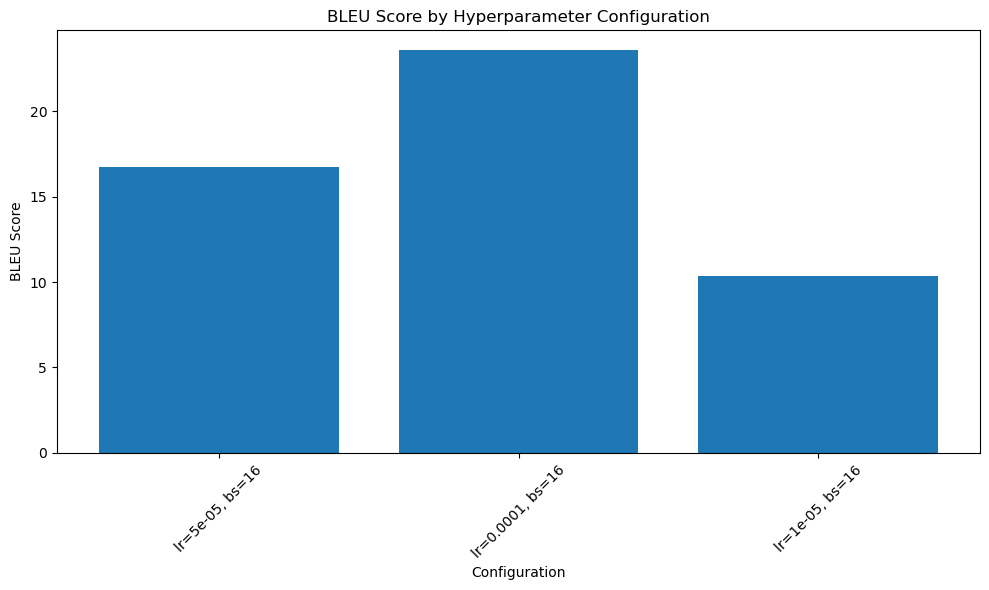

In [28]:
# Define hyperparameter combinations to try
configs = [
    {"learning_rate": 5e-5, "batch_size": 16, "epochs": 2},  # original configuration
    {"learning_rate": 1e-4, "batch_size": 16, "epochs": 2},  # Higher learning rate
    {"learning_rate": 1e-5, "batch_size": 16, "epochs": 2},  # Lower learning rate
    {"learning_rate": 5e-5, "batch_size": 32, "epochs": 2},  # Larger batch size (if GPU memory allows)
]

# Run experiments
results = []
for config in configs:
    config_name = f"lr_{config['learning_rate']}_bs_{config['batch_size']}"
    print(f"\nTesting configuration: {config_name}")
    
    try:
        # Load a fresh model
        fresh_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-es-ar")
        fresh_model.to(device)
        
        # Create training arguments
        training_args = Seq2SeqTrainingArguments(
            output_dir=f"./results/{config_name}",
            eval_strategy="epoch",
            learning_rate=config["learning_rate"],
            per_device_train_batch_size=config["batch_size"],
            per_device_eval_batch_size=config["batch_size"],
            weight_decay=0.01,
            save_total_limit=1,
            num_train_epochs=config["epochs"],
            predict_with_generate=True,
            fp16=True,
            report_to=None
        )
        
        # Create trainer
        trainer = Seq2SeqTrainer(
            model=fresh_model,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )
        
        # Train and time it
        start_time = time.time()
        trainer.train()
        train_time = (time.time() - start_time) / 60  # in minutes
        
        # Evaluate
        eval_result = trainer.evaluate()
        
        # Record results
        result = {
            "learning_rate": config["learning_rate"],
            "batch_size": config["batch_size"],
            "epochs": config["epochs"],
            "bleu": eval_result["eval_bleu"],
            "eval_loss": eval_result["eval_loss"],
            "train_time_mins": train_time
        }
        results.append(result)
        
        # Log experiment
        log_experiment(
            config_name,
            {"learning_rate": config["learning_rate"], 
             "batch_size": config["batch_size"], 
             "epochs": config["epochs"]},
            {"bleu": eval_result["eval_bleu"], 
             "eval_loss": eval_result["eval_loss"], 
             "train_time": train_time}
        )
        
        print(f"Configuration {config_name} results:")
        print(f"BLEU: {eval_result['eval_bleu']:.2f}")
        print(f"Loss: {eval_result['eval_loss']:.4f}")
        print(f"Training time: {train_time:.2f} minutes")
        
    except Exception as e:
        print(f"Error with configuration {config_name}: {e}")

# Find best configuration
if results:
    best_result = max(results, key=lambda x: x["bleu"])
    print("\nBest configuration:")
    print(f"Learning rate: {best_result['learning_rate']}")
    print(f"Batch size: {best_result['batch_size']}")
    print(f"BLEU: {best_result['bleu']:.2f}")
    print(f"Training time: {best_result['train_time_mins']:.2f} minutes")
    
    # Visualize results
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.bar(
        [f"lr={r['learning_rate']}, bs={r['batch_size']}" for r in results],
        [r["bleu"] for r in results]
    )
    plt.xlabel("Configuration")
    plt.ylabel("BLEU Score")
    plt.title("BLEU Score by Hyperparameter Configuration")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("hyperparameter_comparison.png")
    plt.show()

In [29]:
# Train final model with best hyperparameters
def train_final_model(learning_rate, batch_size, epochs=4):
    print(f"Training final model with lr={learning_rate}, bs={batch_size}, epochs={epochs}")
    
    # Load a fresh model
    final_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-es-ar")
    final_model.to(device)
    
    # Create training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir="./results/final_model",
        eval_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        save_total_limit=1,
        num_train_epochs=epochs,
        predict_with_generate=True,
        fp16=True,
        report_to=None
    )
    
    # Create trainer
    trainer = Seq2SeqTrainer(
        model=final_model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    
    # Train
    trainer.train()
    
    # Evaluate on validation set
    val_results = trainer.evaluate()
    print(f"Validation results: {val_results}")
    
    # Evaluate on test set
    test_results = trainer.evaluate(tokenized_datasets["test"])
    print(f"Test results: {test_results}")
    
    # Save model
    model_save_path = "./models/final_model"
    trainer.save_model(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"Final model saved to {model_save_path}")
    
    return final_model, val_results, test_results

In [34]:
# Replace these with the best values from your hyperparameter search
best_lr = 0.0001
best_bs = 16   

In [35]:
final_model, val_results, test_results = train_final_model(best_lr, best_bs, epochs=4)

Training final model with lr=0.0001, bs=16, epochs=4


/tmp/ipykernel_342921/2017205803.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu
1,No log,0.304799,23.718204
2,No log,0.295847,23.488616
3,No log,0.294870,23.255984
4,No log,0.295091,24.102764


/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62517]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/home/maquiroz/miniconda3/envs/spanish_arabic/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Validation results: {'eval_loss': 0.29509130120277405, 'eval_bleu': 24.10276445831119, 'eval_runtime': 371.9265, 'eval_samples_per_second': 4.657, 'eval_steps_per_second': 0.043, 'epoch': 4.0}
Test results: {'eval_loss': 0.30433565378189087, 'eval_bleu': 23.72718282055076, 'eval_runtime': 372.6428, 'eval_samples_per_second': 4.648, 'eval_steps_per_second': 0.043, 'epoch': 4.0}
Final model saved to ./models/final_model


In [32]:
# Comprehensive evaluation of final model
def evaluate_final_model(model, tokenizer, num_examples=100):
    """Evaluate the final model on test set with optimized beam search."""
    print("Running final evaluation with optimized beam search...")
    
    # Sample from test set
    import random
    random.seed(42)
    
    if len(test_df) > num_examples:
        sampled_indices = random.sample(range(len(test_df)), num_examples)
        test_sample = test_df.iloc[sampled_indices]
    else:
        test_sample = test_df
    
    results = []
    
    for _, row in test_sample.iterrows():
        spanish_text = row["spanish"]
        reference = row["arabic"]
        
        # Translate with optimized beam search (5 beams)
        inputs = tokenizer(spanish_text, return_tensors="pt").to(device)
        outputs = model.generate(
            **inputs, 
            num_beams=5,  # Our best strategy
            max_length=128
        )
        translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Calculate BLEU
        sentence_bleu = metric.compute(predictions=[translation], references=[[reference]])
        
        # Record results
        results.append({
            "spanish": spanish_text,
            "spanish_length": len(spanish_text.split()),
            "reference": reference,
            "translation": translation,
            "bleu": sentence_bleu["score"]
        })
    
    # Calculate overall BLEU
    translations = [r["translation"] for r in results]
    references = [[r["reference"]] for r in results]
    overall_bleu = metric.compute(predictions=translations, references=references)
    
    print(f"Overall BLEU on {len(results)} examples: {overall_bleu['score']:.2f}")
    
    # Show examples with best and worst performance
    sorted_results = sorted(results, key=lambda x: x["bleu"], reverse=True)
    
    print("\nBest translations:")
    for r in sorted_results[:3]:
        print(f"Spanish: {r['spanish']}")
        print(f"Translation: {r['translation']}")
        print(f"Reference: {r['reference']}")
        print(f"BLEU: {r['bleu']:.2f}")
        print("-" * 70)
    
    print("\nWorst translations:")
    for r in sorted_results[-3:]:
        print(f"Spanish: {r['spanish']}")
        print(f"Translation: {r['translation']}")
        print(f"Reference: {r['reference']}")
        print(f"BLEU: {r['bleu']:.2f}")
        print("-" * 70)
    
    # Analyze performance by sentence length
    import pandas as pd
    import matplotlib.pyplot as plt
    
    results_df = pd.DataFrame(results)
    
    # Group by sentence length
    results_df["length_bin"] = pd.cut(
        results_df["spanish_length"],
        bins=[0, 5, 10, 15, 20, float('inf')],
        labels=["1-5", "6-10", "11-15", "16-20", "20+"]
    )
    
    length_analysis = results_df.groupby("length_bin").agg({
        "bleu": ["mean", "count"]
    })
    
    print("\nPerformance by sentence length:")
    print(length_analysis)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(
        length_analysis.index,
        length_analysis[("bleu", "mean")]
    )
    plt.xlabel("Sentence Length (words)")
    plt.ylabel("Average BLEU Score")
    plt.title("Translation Quality by Sentence Length")
    for i, v in enumerate(length_analysis[("bleu", "mean")]):
        plt.text(i, v + 0.5, f"{v:.2f}", ha='center')
    plt.savefig("bleu_by_length.png")
    plt.show()
    
    return results_df, overall_bleu["score"]

Running final evaluation with optimized beam search...
Overall BLEU on 100 examples: 27.06

Best translations:
Spanish: 1. suprímase el párrafo 1.
Translation: 1- تحذف الفقره 1.
Reference: 1- تحذف الفقره 1.
BLEU: 100.00
----------------------------------------------------------------------
Spanish: c. préstamos a empleados
Translation: جيم - قروض الموظفين
Reference: جيم - قروض الموظفين
BLEU: 100.00
----------------------------------------------------------------------
Spanish: iii. aplicación de recomendaciones anteriores de la comisión consultiva en asuntos administrativos y de presupuesto
Translation: ثالثا - تنفيذ التوصيات السابقه للجنه الاستشاريه لشءون الاداره والميزانيه
Reference: الثالث - تنفيذ التوصيات السابقه للجنه الاستشاريه لشءون الاداره والميزانيه
BLEU: 88.01
----------------------------------------------------------------------

Worst translations:
Spanish: anastacia, sus amigas y todos salieron de fiesta a bailar toda la noche.
Translation: ‫"انستاسي" واصدقاءها والجميع‬ ‫ك

/tmp/ipykernel_342921/3991556216.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_analysis = results_df.groupby("length_bin").agg({


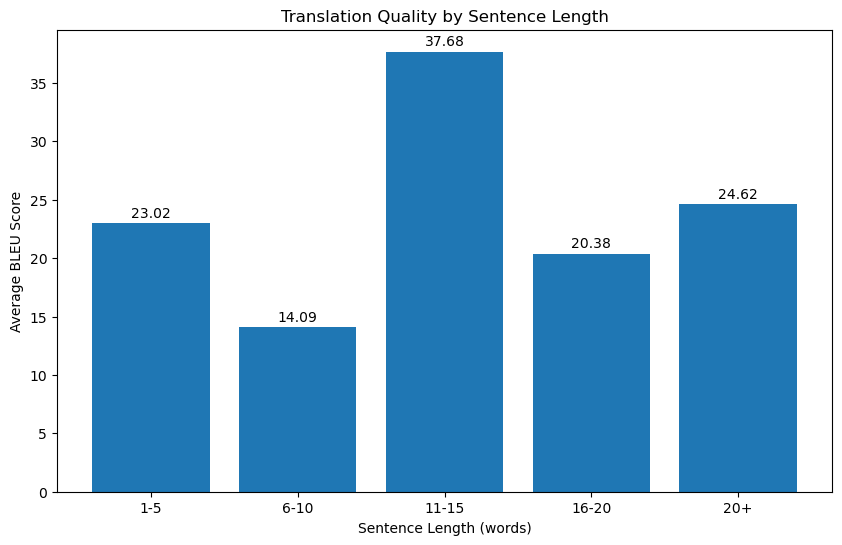

In [36]:
# Evaluate your final model
final_results, final_bleu = evaluate_final_model(final_model, tokenizer)

In [37]:
def translate_with_optimal_settings(spanish_text):
    """Translate Spanish to Arabic using optimal settings."""
    # Load the final model
    model_path = "./models/final_model"
    model = MarianMTModel.from_pretrained(model_path)
    tokenizer = MarianTokenizer.from_pretrained(model_path)
    
    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Tokenize
    inputs = tokenizer(spanish_text, return_tensors="pt").to(device)
    
    # Generate with optimal settings
    outputs = model.generate(
        **inputs, 
        num_beams=5,  # Our best strategy
        max_length=128
    )
    
    # Decode
    translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translation

In [38]:
example_texts = [
    "La paz y la cooperación internacional son fundamentales para el desarrollo sostenible.",
    "¿Cuál es la fecha límite para entregar el informe?",
    "Los niños jugaban en el parque mientras sus padres conversaban.",
    "El cambio climático representa una amenaza para todos los países del mundo."
]

for text in example_texts:
    translation = translate_with_optimal_settings(text)
    print(f"Spanish: {text}")
    print(f"Arabic: {translation}")
    print("-" * 70)

Spanish: La paz y la cooperación internacional son fundamentales para el desarrollo sostenible.
Arabic: فالسلام والتعاون الدولي عاملان حيويان لتحقيق التنميه المستدامه.
----------------------------------------------------------------------
Spanish: ¿Cuál es la fecha límite para entregar el informe?
Arabic: ما هو الموعد النهاءي لتقديم التقرير؟
----------------------------------------------------------------------
Spanish: Los niños jugaban en el parque mientras sus padres conversaban.
Arabic: الاطفال كانوا يلعبون في المنتزه بينما كان والداهم يتحدثان
----------------------------------------------------------------------
Spanish: El cambio climático representa una amenaza para todos los países del mundo.
Arabic: ويمثل تغير المناخ تهديدا لجميع بلدان العالم.
----------------------------------------------------------------------
